<a href="https://colab.research.google.com/github/enum123/ASSIGNMENT_2/blob/main/Image_Classification_on_Cifar10_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
# Importing TensorFlow and Keras libraries for deep learning
import tensorflow as tf
from tensorflow.keras.datasets import cifar10  # Loading the CIFAR-10 dataset for image classification
from tensorflow.keras.models import Sequential, Model  # Building models by stacking layers sequentially
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization  # Core layers for building CNNs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau  # Callbacks for training optimization
from tensorflow.keras.regularizers import l2  # Regularization to prevent overfitting
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Performing data augmentation
from tensorflow.keras.layers import Input  # Defining input layer structure
from tensorflow.keras.optimizers import Adamax  # Optimizer for training the model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import VGG19, MobileNet
# Libraries for data visualization and mathematical operations
import matplotlib.pyplot as plt  # Visualizing data and model performance
import seaborn as sns
import numpy as np  # Performing numerical computations and handling arrays


# Getting DataSet

In [ ]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Normalize data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

# One-hot encode labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


# Performing Data Augmentation

In [ ]:
# Data augmentation for the training set
datagen = ImageDataGenerator(
    rotation_range=15,          # Randomly rotate images within a range of 15 degrees
    width_shift_range=0.1,      # Randomly shift images horizontally by up to 10% of the width
    height_shift_range=0.1,     # Randomly shift images vertically by up to 10% of the height
    horizontal_flip=True,       # Randomly flip images horizontally
    zoom_range=0.1              # Randomly zoom in or out by up to 10%
)

# Fit the data generator on the training data to compute statistics like mean and std
datagen.fit(x_train)

# Data augmentation for the validation set (minimal augmentation is usually recommended)
val_datagen = ImageDataGenerator(
    rotation_range=10,          # Rotate images within a smaller range (10 degrees)
    width_shift_range=0.05,     # Slight horizontal shift (5%)
    height_shift_range=0.05,    # Slight vertical shift (5%)
    horizontal_flip=True        # Enable horizontal flipping for slight variations
)

# Fit the data generator on the validation data
val_datagen.fit(x_val)

# Example: To generate augmented images for training, use datagen.flow()
train_generator = datagen.flow(x_train, y_train, batch_size=32)
val_generator = val_datagen.flow(x_val, y_val, batch_size=32)

# Print message to confirm
print("Data augmentation applied to training and validation sets.")


Data augmentation applied to training and validation sets.


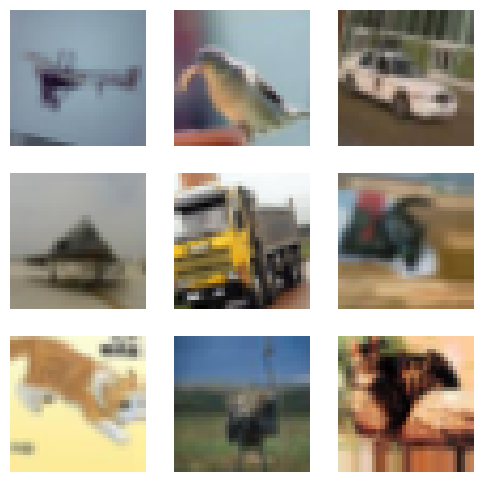

In [ ]:
# Display a 3x3 grid of augmented images
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):  # Generate a batch of 9 images
    plt.figure(figsize=(6, 6))  # Set figure size
    for i in range(9):  # Loop through the 9 images in the batch
        plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
        plt.imshow(x_batch[i])  # Display the image
        plt.axis('off')  # Hide axes for better visualization
    plt.show()
    break  # Display one batch and exit the loop


# Defining The Model Structure

In [ ]:
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10, kernel_regularizer_val=0.01, dropout_rate=0.25, dense_dropout_rate=0.5):
    model = Sequential([
        Input(shape=input_shape),

        # Block 1 Conv2D layers + BatchNormalization + MaxPooling + Dropout
        Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Block 2 Conv2D layers + BatchNormalization + MaxPooling + Dropout
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Block 3 Conv2D layers + BatchNormalization + MaxPooling + Dropout
        Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Block 4 Conv2D layers + BatchNormalization + MaxPooling + Dropout
        Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Block 5 Conv2D layers (10th Conv2D added here) + BatchNormalization + MaxPooling + Dropout
        Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        # Fully connected layers
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Dense(256, activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        BatchNormalization(),
        Dense(128, activation='relu', kernel_regularizer=l2(kernel_regularizer_val)),
        Dropout(dense_dropout_rate),
        Dense(num_classes, activation='softmax')  # Output layer for `num_classes` classes
    ])
    return model

model = create_cnn_model(input_shape=(32, 32, 3), num_classes=10, kernel_regularizer_val=0.01, dropout_rate=0.3, dense_dropout_rate=0.5)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,151,402 (19.65 MB)

 Trainable params: 5,145,898 (19.63 MB)

 Non-trainable params: 5,504 (21.50 KB)

# Compliling the Model

In [ ]:
# Compile model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the Model

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),              # Stop if no improvement
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)                          # Reduce learning rate
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),  # Training data with augmentation
    epochs=50,
    validation_data= datagen.flow(x_val, y_val, batch_size=32),              # Validation data
    callbacks=callbacks                            # Add callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 63s 35ms/step - accuracy: 0.2090 - loss: 24.3915 - val_accuracy: 0.3099 - val_loss: 11.1037 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 33ms/step - accuracy: 0.3845 - loss: 8.3774 - val_accuracy: 0.4199 - val_loss: 3.6390 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.4499 - loss: 3.0698 - val_accuracy: 0.4198 - val_loss: 2.4403 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.4910 - loss: 2.1853 - val_accuracy: 0.5269 - val_loss: 1.9358 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 78s 33ms/step - accuracy: 0.5359 - loss: 1.9749 - val_accuracy: 0.5350 - val_loss: 1.9312 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.5625 - loss: 1.8778 - val_accuracy: 0.5670 - val_loss: 1.8444 - learning_rate: 0.0010
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.589

# Training Curves

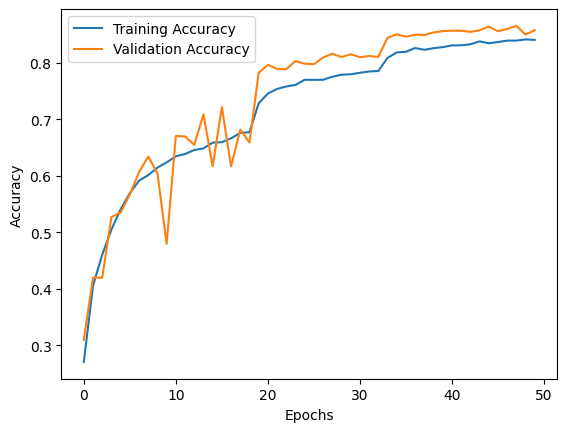

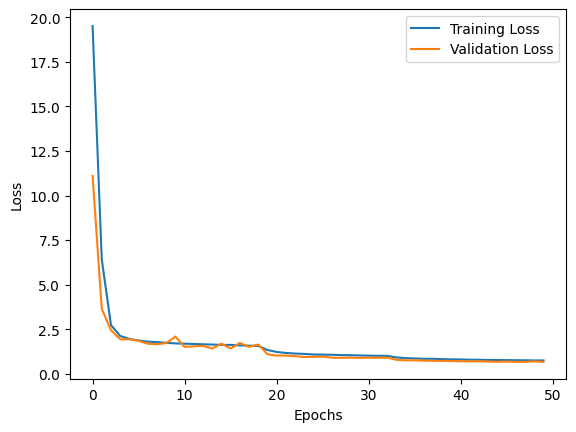

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Model Evaluation on Test Set

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8628 - loss: 0.6597
Test Loss: 0.6584
Test Accuracy: 0.8627


# Plot Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


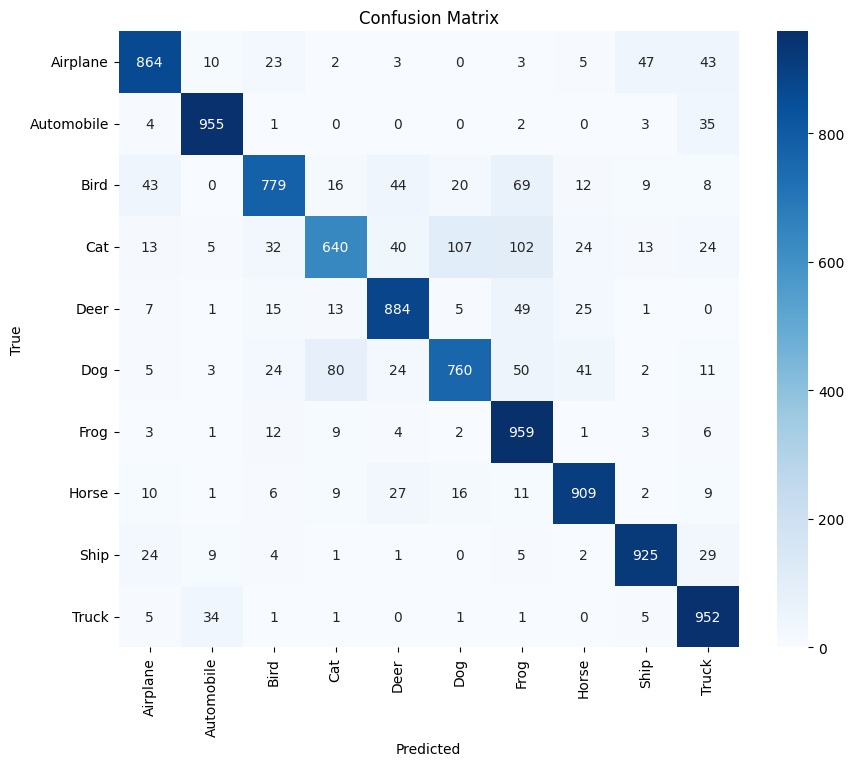

In [ ]:
# Generate predictions on the test set
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# CIFAR-10 class names
cifar10_classes = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Using Transfer Learning VGG19 Model

In [ ]:
# Build VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Unfreeze the last two layers of the base model
for layer in base_model.layers[:-2]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=50,
    validation_data=datagen.flow(x_val, y_val, batch_size=64),
    callbacks=callbacks
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.4201 - loss: 3.7750 - val_accuracy: 0.5153 - val_loss: 1.9157 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.5362 - loss: 1.7379 - val_accuracy: 0.5635 - val_loss: 1.4341 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.5658 - loss: 1.3877 - val_accuracy: 0.5830 - val_loss: 1.2665 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.5839 - loss: 1.2643 - val_accuracy: 0.5769 - val_loss: 1.2551 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.5895 - loss: 1.2298 - val_accuracy: 0.5923 - val_loss: 1.2169 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 64ms/step - accuracy: 0.6044 - loss: 1.1801 - val_accuracy: 0.5927 - val_loss: 1.1983 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 58ms/step - accuracy: 0.6077 - l

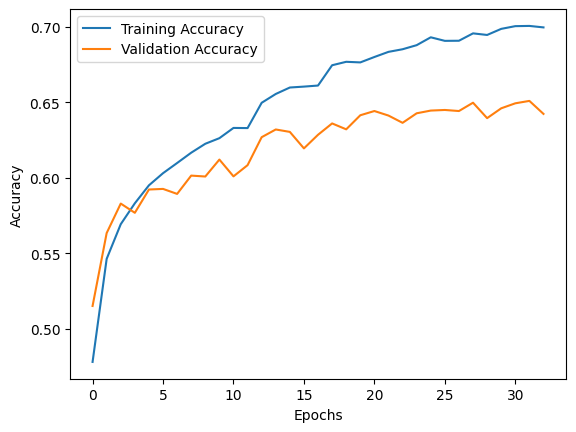

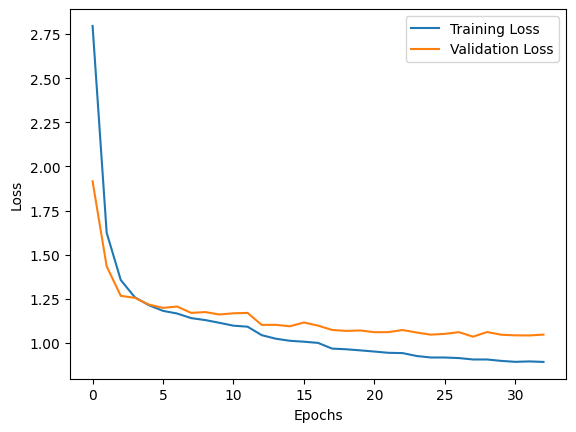

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluation VGG19

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6741 - loss: 0.9732
Test Loss: 0.9810
Test Accuracy: 0.6730


# Plotting Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step


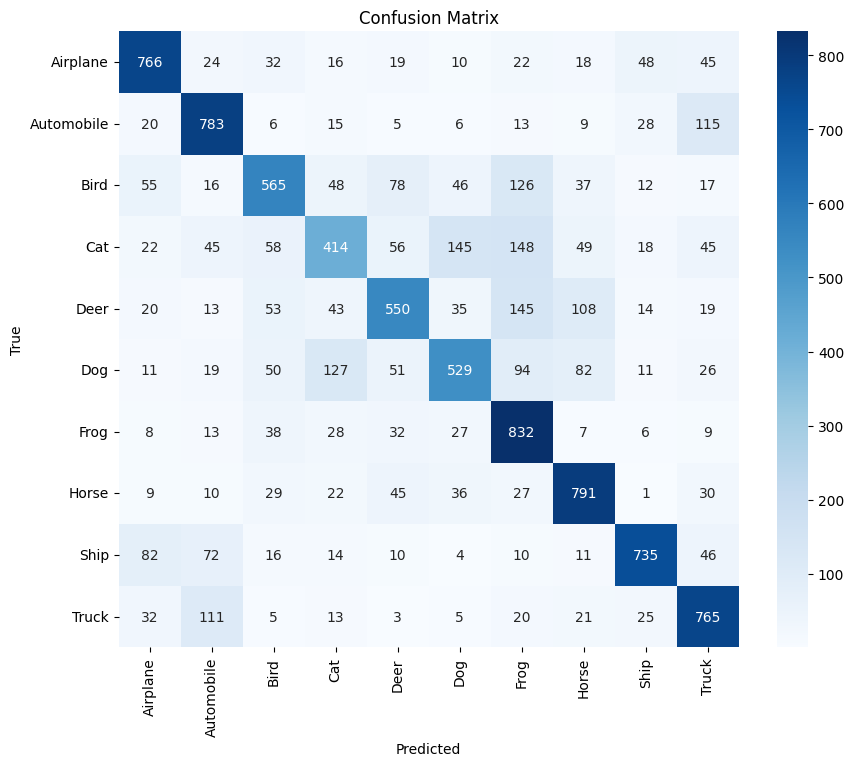

In [ ]:
# Generate predictions on the test set
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# CIFAR-10 class names
cifar10_classes = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Importing MobileNet

In [ ]:
# Build MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Unfreeze the last two layers of the base model
for layer in base_model.layers[:-2]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


<ipython-input-28-5b04e6eb6396>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=50,
    validation_data=datagen.flow(x_val, y_val, batch_size=64),
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.3873 - loss: 7.1850 - val_accuracy: 0.5111 - val_loss: 3.5687 - learning_rate: 0.0010
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 60ms/step - accuracy: 0.5130 - loss: 3.0806 - val_accuracy: 0.5482 - val_loss: 2.0419 - learning_rate: 0.0010
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.5236 - loss: 1.9614 - val_accuracy: 0.5431 - val_loss: 1.6406 - learning_rate: 0.0010
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.5315 - loss: 1.6518 - val_accuracy: 0.5422 - val_loss: 1.5292 - learning_rate: 0.0010
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 55ms/step - accuracy: 0.5359 - loss: 1.5434 - val_accuracy: 0.5485 - val_loss: 1.4908 - learning_rate: 0.0010
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.5357 - loss: 1.5179 - val_accuracy: 0.5481 - val_loss: 1.4708 - learning_rate: 0.0010
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 52ms/step - accuracy: 0.5398 - loss: 1.4967

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6249 - loss: 1.1575
Test Loss: 1.1607
Test Accuracy: 0.6258


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


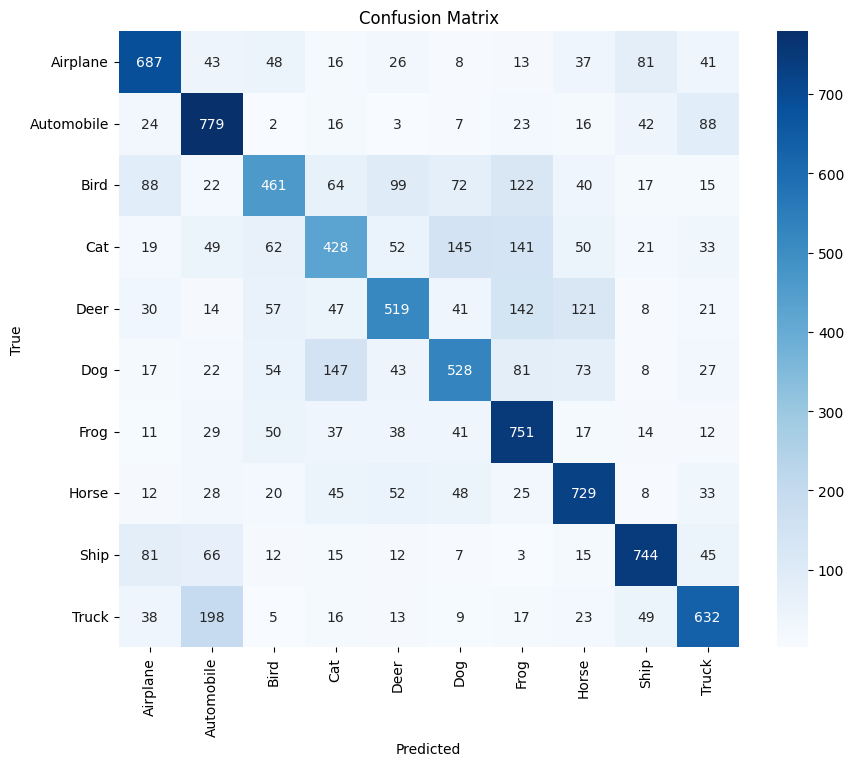

In [ ]:
# Generate predictions on the test set
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# CIFAR-10 class names
cifar10_classes = [
    "Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"
]

# Plot confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()